# Case: 絕緣片瑕疵偵測

Copyright © 2019 Hsu Shih-Chieh

In [27]:
%load_ext autoreload
%autoreload 2
import os, warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import keras, cv2, random, joblib
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split
from skimage.filters import threshold_otsu
from PIL import Image, ImageEnhance
from datasets import load_ADS_generator
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, CSVLogger, TensorBoard, ReduceLROnPlateau, LambdaCallback
from utils import set_font_cn, Bunch
set_font_cn()

#from utils.segmentation_models import Unet, Nestnet, Xnet
import segmentation_models as sm
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as K
from IPython.display import display


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data

In [28]:
#
data = load_ADS_generator()


100%|██████████| 10/10 [00:00<00:00, 323.33it/s]


### Image Augmentation Function

In [29]:
def fillmeangray(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray_flt = img_gray.flatten()
    th = threshold_otsu(img_gray)
    img_gray_flt[np.where(img_gray_flt>th)[0]] = np.mean(img_gray_flt[np.where(img_gray_flt<th)[0]])    
    th = threshold_otsu(img_gray_flt)
    img_gray_flt[np.where(img_gray_flt>th)[0]] = np.mean(img_gray_flt[np.where(img_gray_flt<th)[0]])
    img_rmBack = img_gray_flt.reshape(img_gray.shape)    
    img_rmBack = np.stack([img_rmBack,img_rmBack,img_rmBack], axis=2)
    return img_rmBack

def imgaugmentation(image):
    image = Image.fromarray(image)
    enh_bri = ImageEnhance.Brightness(image)
    image_enhance = enh_bri.enhance(0.1*random.randint(8,12))#亮度
    enh_col = ImageEnhance.Color(image_enhance)
    image_enhance = enh_col.enhance(0.1*random.randint(8,12))#色度增强
    enh_con = ImageEnhance.Contrast(image_enhance)
    image_enhance = enh_con.enhance(0.1*random.randint(8,12))#对比度增强
    enh_sha = ImageEnhance.Sharpness(image_enhance)
    image_enhance = enh_sha.enhance(0.1*random.randint(8,12))#锐度增强
    return image_enhance

def extractDefect(img,mask):
    #maskingray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    y_min, y_max = np.where(np.sum(mask,axis=1)!=0)[0][[0,-1]]
    x_min, x_max = np.where(np.sum(mask,axis=0)!=0)[0][[0,-1]]
    defectImg = img[y_min:y_max, x_min:x_max]
    defectMask = mask[y_min:y_max, x_min:x_max]  
    defectPosition = (y_min, y_max, x_min, x_max)
    return defectImg.copy(), defectMask.copy(), defectPosition   


funs = Bunch(fillmeangray=fillmeangray, imgaugmentation=imgaugmentation, extractDefect=extractDefect)
dataGen = data.dataGenerator


### Check Data

Number of training image: 83


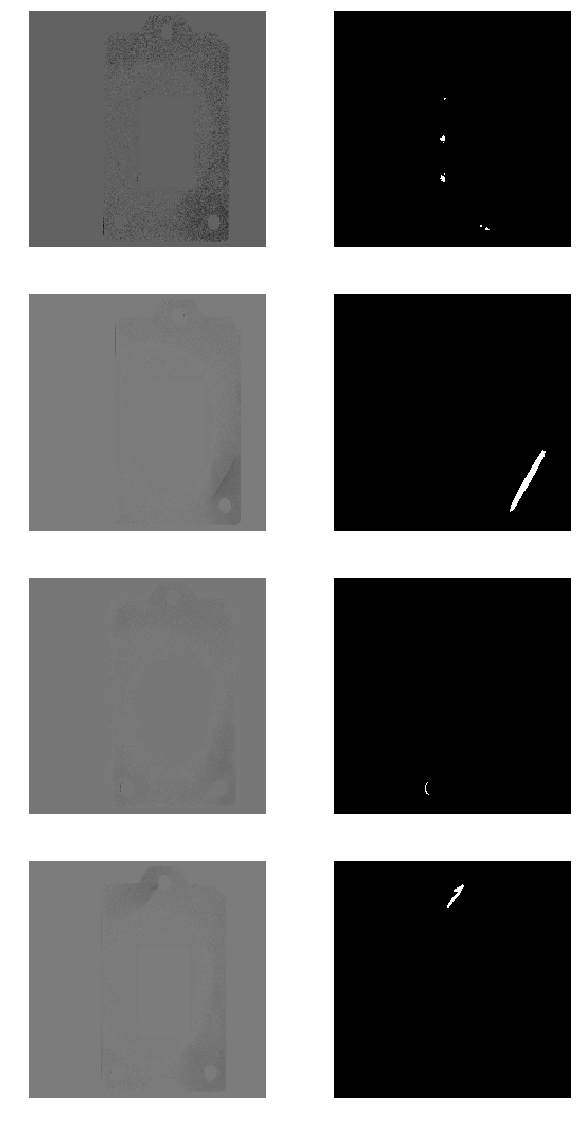

In [30]:
print('Number of training image:',data.trimgQty)

batch = next(dataGen(4, 'val', funs=funs, preprocess=False))
imgs = batch[0]
masks = batch[1]

i=1
plt.figure(figsize=(10,20))
for idx in range(4):
    plt.subplot(420+i)
    i=i+1
    plt.imshow(imgs[idx])
    plt.axis('off')
    plt.subplot(420+i)
    i=i+1
    plt.imshow(np.squeeze(masks[idx]), cmap='gray')
    plt.axis('off')
    


### Pre-Process

### Build Model

In [26]:

#model = Xnet(backbone_name='densenet169', encoder_weights='imagenet',decoder_block_type='transpose') # build UNet++
#model = Unet(backbone_name='resnet50', encoder_weights='imagenet') #UNet
model = sm.Unet('efficientnetb7', encoder_weights='imagenet', classes=1, activation='sigmoid', input_shape=(224, 224, 3), decoder_block_type='transpose')
model.compile(optimizer='Adam', loss=sm.losses.bce_jaccard_loss, metrics=['binary_accuracy'])



'\nEfficientNetB0 - (224, 224, 3)\nEfficientNetB1 - (240, 240, 3)\nEfficientNetB2 - (260, 260, 3)\nEfficientNetB3 - (300, 300, 3)\nEfficientNetB4 - (380, 380, 3)\nEfficientNetB5 - (456, 456, 3)\nEfficientNetB6 - (528, 528, 3)\nEfficientNetB7 - (600, 600, 3)\n'

### Training

In [35]:


callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=8, min_lr=1e-10, min_delta=0.00001, verbose=1, mode='min'),
    #EarlyStopping(monitor='val_loss', patience=10, verbose=0),
    #ModelCheckpoint(config['tempmodel'], monitor='val_loss', save_best_only=True, verbose=0),
    TensorBoard(log_dir='tmp', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch'),
    #CSVLogger('logs/csvlog.csv', append=True, separator=',')
]

print('Start training...')

history = model.fit_generator(dataGen(7, 'tr', funs=funs), steps_per_epoch=15, epochs=200, validation_data=dataGen(5, 'val', funs=funs), validation_steps=4, callbacks=callbacks) 

model.save('model/ads.h5')
joblib.dump(history, 'tmp/history.pkl')
print('Training is finished')


Start training...
Epoch 1/200
15/15 [==============================] - 48s 3s/step - loss: 1.3121 - binary_accuracy: 0.9554 - val_loss: 1.1481 - val_binary_accuracy: 0.9916
Epoch 2/200
15/15 [==============================] - 36s 2s/step - loss: 1.1181 - binary_accuracy: 0.9926 - val_loss: 1.0620 - val_binary_accuracy: 0.9938
Epoch 3/200
15/15 [==============================] - 42s 3s/step - loss: 1.0508 - binary_accuracy: 0.9935 - val_loss: 1.0551 - val_binary_accuracy: 0.9930
Epoch 4/200
15/15 [==============================] - 42s 3s/step - loss: 0.9959 - binary_accuracy: 0.9897 - val_loss: 0.9893 - val_binary_accuracy: 0.9875
Epoch 5/200
15/15 [==============================] - 44s 3s/step - loss: 0.9681 - binary_accuracy: 0.9871 - val_loss: 1.1338 - val_binary_accuracy: 0.9409
Epoch 6/200
15/15 [==============================] - 42s 3s/step - loss: 0.9043 - binary_accuracy: 0.9913 - val_loss: 1.0397 - val_binary_accuracy: 0.9491
Epoch 7/200
15/15 [==============================] -

15/15 [==============================] - 43s 3s/step - loss: 0.5902 - binary_accuracy: 0.9957 - val_loss: 0.8694 - val_binary_accuracy: 0.9939
Epoch 101/200
15/15 [==============================] - 43s 3s/step - loss: 0.5513 - binary_accuracy: 0.9960 - val_loss: 0.9364 - val_binary_accuracy: 0.9906

Epoch 00101: ReduceLROnPlateau reducing learning rate to 8.589935605414213e-05.
Epoch 102/200
15/15 [==============================] - 43s 3s/step - loss: 0.5602 - binary_accuracy: 0.9953 - val_loss: 0.9269 - val_binary_accuracy: 0.9935
Epoch 103/200
15/15 [==============================] - 43s 3s/step - loss: 0.5918 - binary_accuracy: 0.9957 - val_loss: 0.8602 - val_binary_accuracy: 0.9939
Epoch 104/200
15/15 [==============================] - 43s 3s/step - loss: 0.5821 - binary_accuracy: 0.9959 - val_loss: 0.8761 - val_binary_accuracy: 0.9939
Epoch 105/200
15/15 [==============================] - 44s 3s/step - loss: 0.5340 - binary_accuracy: 0.9959 - val_loss: 0.8590 - val_binary_accuracy

15/15 [==============================] - 42s 3s/step - loss: 0.5336 - binary_accuracy: 0.9961 - val_loss: 0.8869 - val_binary_accuracy: 0.9934
Epoch 199/200
15/15 [==============================] - 43s 3s/step - loss: 0.5516 - binary_accuracy: 0.9961 - val_loss: 0.8712 - val_binary_accuracy: 0.9935
Epoch 200/200
15/15 [==============================] - 43s 3s/step - loss: 0.5363 - binary_accuracy: 0.9959 - val_loss: 0.8934 - val_binary_accuracy: 0.9939
Training is finished


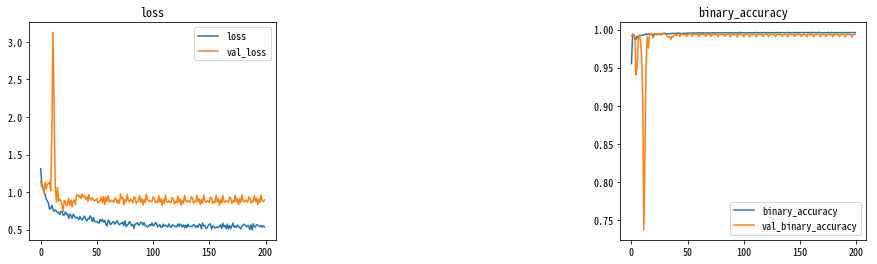

In [40]:
#history = joblib.load('tmp/history.pkl')
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
#plt.ylim(0,0.1)
plt.legend()
plt.title('loss')

'''
plt.subplot(132)
plt.plot(history.history['iou_score'], label='iou_score')
plt.plot(history.history['val_iou_score'], label='val_iou_score')
plt.legend()
plt.title('iou_score')
'''

plt.subplot(133)
plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')
plt.legend()
plt.title('binary_accuracy')
plt.show()




**Validation**


In [ ]:
socre = model.evaluate_generator(dataGen(50, 'tr', funs=funs), steps=1, verbose=1)
scoredict = dict(zip(model.metrics_names, socre))
print(scoredict)

In [ ]:
socre = model.evaluate_generator(dataGen(20, 'val', funs=funs), steps=1, verbose=1)
scoredict = dict(zip(model.metrics_names, socre))
print(scoredict)

**Test**

10/10 [==============================] - 18s 2s/step


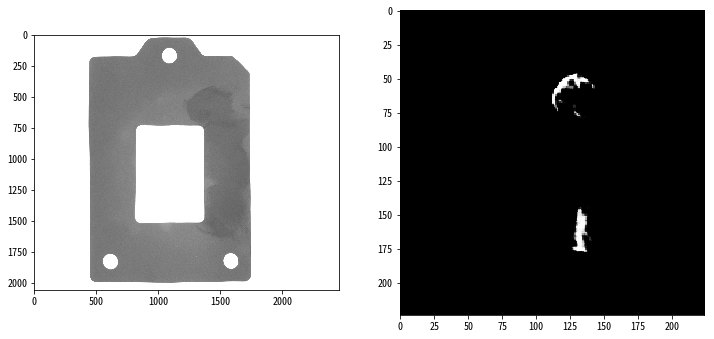

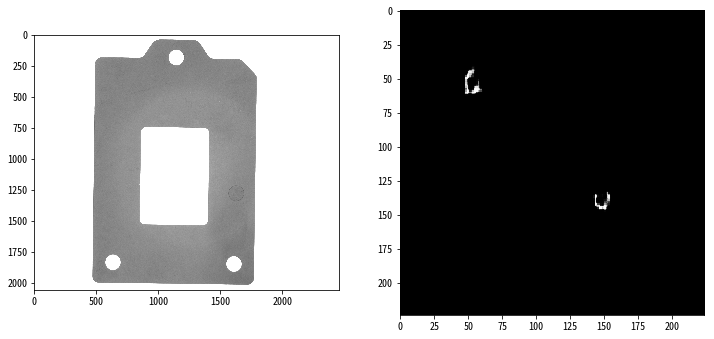

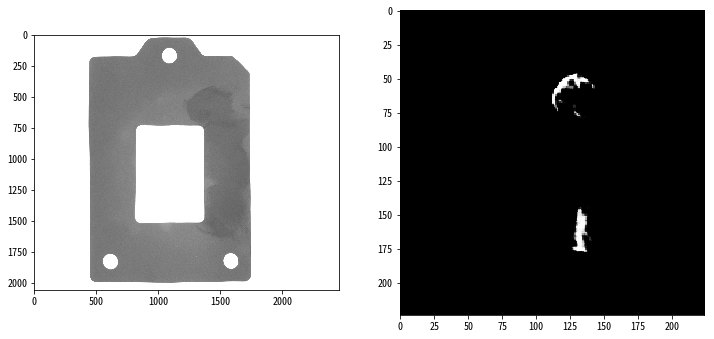

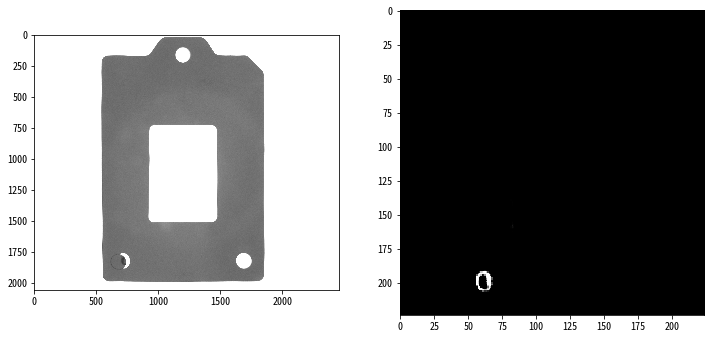

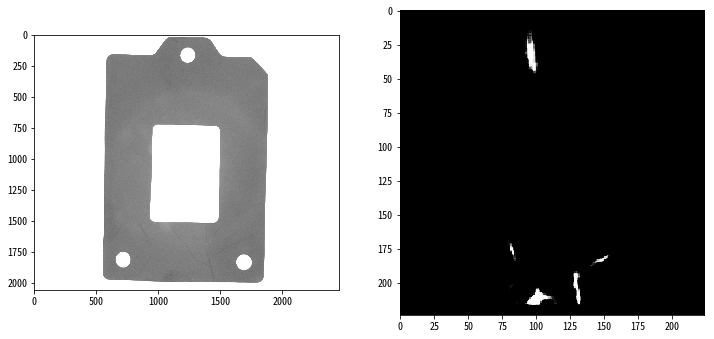

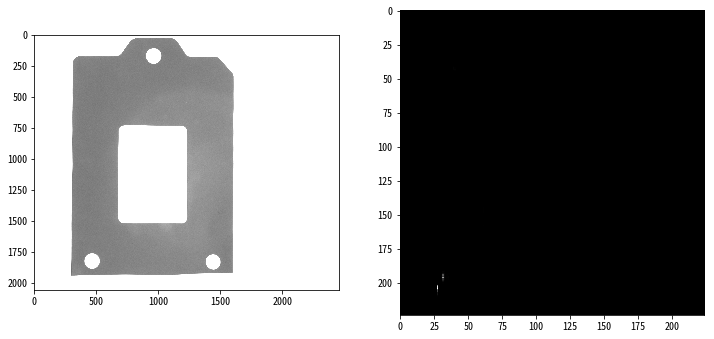

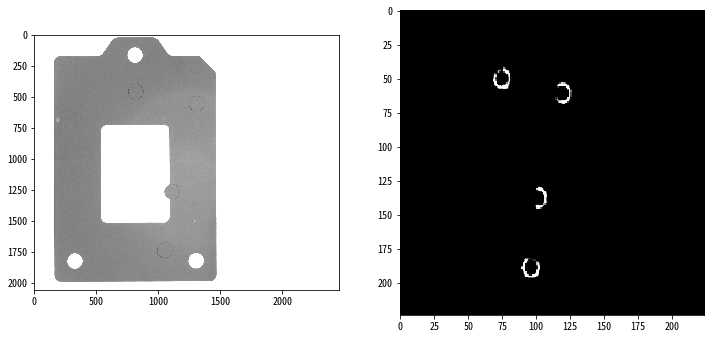

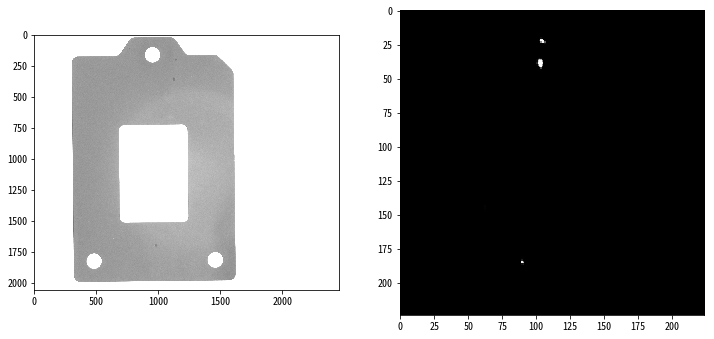

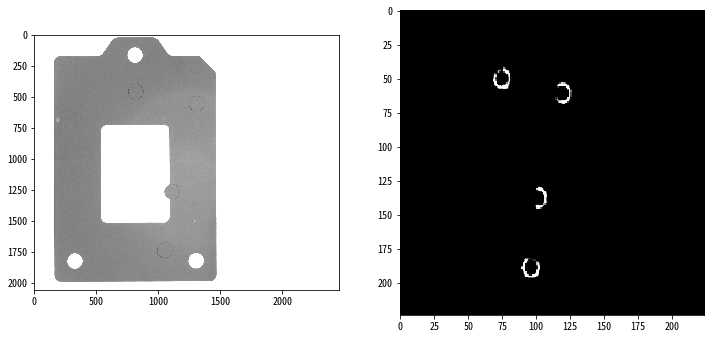

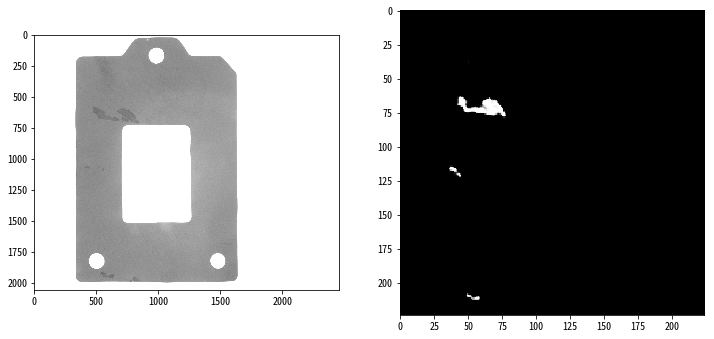

In [41]:
preprocess_input = sm.get_preprocessing('densenet169')    
ts = data.testImgs
ts_tmp = list(map(lambda x:  preprocess_input(np.array(Image.fromarray(fillmeangray(x)).resize((224, 224), Image.NEAREST))), ts))
preds_test = model.predict(np.array(ts_tmp), verbose=1) 
#preds_test = (preds_test > 0.1).astype(np.uint8)


for ix in range(preds_test.shape[0]):
    pr = preds_test[ix]
    rawimg = ts[ix]
    fig = plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.imshow(rawimg)
    plt.subplot(122)
    plt.imshow(np.squeeze(pr), cmap='gray')
    plt.show()
    
    
